In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
from tools import *

%matplotlib inline

In [2]:
raw_results = list()
for filename in ['results/2019-10-21T12:54:05.214105-04:00.json',
                 'results/2019-10-21T13:33:45.218596-04:00.json',
                 'results/2019-10-22T21:44:40.382425-04:00.json',
                 'results/2019-11-01T10:41:03.725361-04:00.json',
                 'results/2019-11-20T16:10:25.953696-05:00.json',
                 'results/2019-11-21T12:10:12.259298-05:00.json']:
    with open(filename, 'r') as infile:
        raw_results += json.load(infile)
results = list_of_dicts_to_dict_of_lists(raw_results)
for key, value in results.items():
    results[key] = to_nested_tuples(value)
results = pd.DataFrame(data=results)
masks = pd.read_csv('mnist_masks.csv')

In [12]:
rdf = results.copy(deep=True)
rdf = rdf[rdf['success']]
for i in rdf.index:
    if (rdf.at[i, 'optimizer'] == 'sgd') and (str(rdf.at[i, 'momentum']) != '0.0'):
        if float(rdf.at[i, 'momentum']) > 0:
            rdf.at[i, 'optimizer'] = 'momentum'
        else:
            assert(float(rdf.at[i, 'momentum']) < 0)
            rdf.at[i, 'optimizer'] = 'imomentum'
    if (rdf.at[i, 'optimizer'] == 'rms') and (float(rdf.at[i, 'rho']) < 0):
        rdf.at[i, 'optimizer'] = 'irms'
optimizer_nice_names = {'adam': 'Adam', 'momentum': 'Momentum', 'rms': 'RMSProp', 'sgd': 'SGD', 'nmom': 'IMomentum'}

In [4]:
rdf = rdf[rdf['criteria'] == 'online']
rdf = rdf[rdf['phases'].apply(len) == 4]
# rdf = rdf[rdf['phases'].apply(len) == 8]
# rdf = rdf[rdf['phases'].apply(len) == 16]
summary = get_summary(rdf)
best = get_best(summary, 'time')
only_best = get_only_best(rdf, best)

In [5]:
max_phase_lengths = list()
for _, row in only_best.iterrows():
    for i, l in enumerate(row['phase_length']):
        if len(max_phase_lengths) == i:
            max_phase_lengths.append(0)
        max_phase_lengths[i] = max(max_phase_lengths[i], l)
data = dict()
for k,v in best.items():
    data[k] = dict()
    data[k]['count'] = [np.zeros(i, dtype=int) for i in max_phase_lengths]
    for k2 in ['count',
               'd1_avg',
               'd1_sec',
               'd1_min',
               'd1_max',
               'd2_avg',
               'd2_sec',
               'd2_min',
               'd2_max',
               'online_avg',
               'online_sec',
               'online_min',
               'online_max']:
        data[k][k2] = [np.zeros(i, dtype=float) for i in max_phase_lengths]
    data[k]['phase_lengths'] = [list() for i in max_phase_lengths]
    for i in range(len(max_phase_lengths)):
        data[k]['d1_min'][i] += 1
        data[k]['d2_min'][i] += 1
    kdf = only_best[only_best['optimizer'] == k]
    for _, row in kdf.iterrows():
        j = 0
        for i, l in enumerate(row['phase_length']):
            data[k]['count'][i][:l] += 1
            data[k]['phase_lengths'][i].append(l)

            accuracies = np.array(row['accuracies'])[j:j + l, 0]
            delta = accuracies - data[k]['d1_avg'][i][:len(accuracies)]
            data[k]['d1_avg'][i][:len(delta)] += delta / data[k]['count'][i][:len(accuracies)]
            data[k]['d1_sec'][i][:len(delta)] += delta * (accuracies - data[k]['d1_avg'][i][:len(accuracies)])
            data[k]['d1_min'][i][:len(accuracies)] = np.minimum(data[k]['d1_min'][i][:len(accuracies)], accuracies)
            data[k]['d1_max'][i][:len(accuracies)] = np.maximum(data[k]['d1_max'][i][:len(accuracies)], accuracies)

            accuracies = np.array(row['accuracies'])[j:j + l, 1]
            delta = accuracies - data[k]['d2_avg'][i][:len(accuracies)]
            data[k]['d2_avg'][i][:len(delta)] += delta / data[k]['count'][i][:len(accuracies)]
            data[k]['d2_sec'][i][:len(delta)] += delta * (accuracies - data[k]['d2_avg'][i][:len(accuracies)])
            data[k]['d2_min'][i][:len(accuracies)] = np.minimum(data[k]['d2_min'][i][:len(accuracies)], accuracies)
            data[k]['d2_max'][i][:len(accuracies)] = np.maximum(data[k]['d2_max'][i][:len(accuracies)], accuracies)

            accuracies = np.cumsum(np.array(row['correct'])[j:j + l]) / (np.arange(l) + 1)
            delta = accuracies - data[k]['online_avg'][i][:len(accuracies)]
            data[k]['online_avg'][i][:len(delta)] += delta / data[k]['count'][i][:len(accuracies)]
            data[k]['online_sec'][i][:len(delta)] += delta * (accuracies - data[k]['online_avg'][i][:len(accuracies)])
            data[k]['online_min'][i][:len(accuracies)] = np.minimum(data[k]['online_min'][i][:len(accuracies)], accuracies)
            data[k]['online_max'][i][:len(accuracies)] = np.maximum(data[k]['online_max'][i][:len(accuracies)], accuracies)
            
            j += l
    data[k]['d1_sem'] = list()
    data[k]['d2_sem'] = list()
    data[k]['online_sem'] = list()
    for i in range(len(max_phase_lengths)):
        data[k]['d1_sem'].append(np.nan_to_num(np.sqrt(data[k]['d1_sec'][i]) / data[k]['count'][i]))
        data[k]['d2_sem'].append(np.nan_to_num(np.sqrt(data[k]['d2_sec'][i]) / data[k]['count'][i]))
        data[k]['online_sem'].append(np.nan_to_num(np.sqrt(data[k]['online_sec'][i]) / data[k]['count'][i]))
    del data[k]['d1_sec']
    del data[k]['d2_sec']
    del data[k]['online_sec']

/Users/dylanashley/.miniconda3/envs/tensorflow-1.13.1/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/tensorflow-1.13.1/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/tensorflow-1.13.1/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


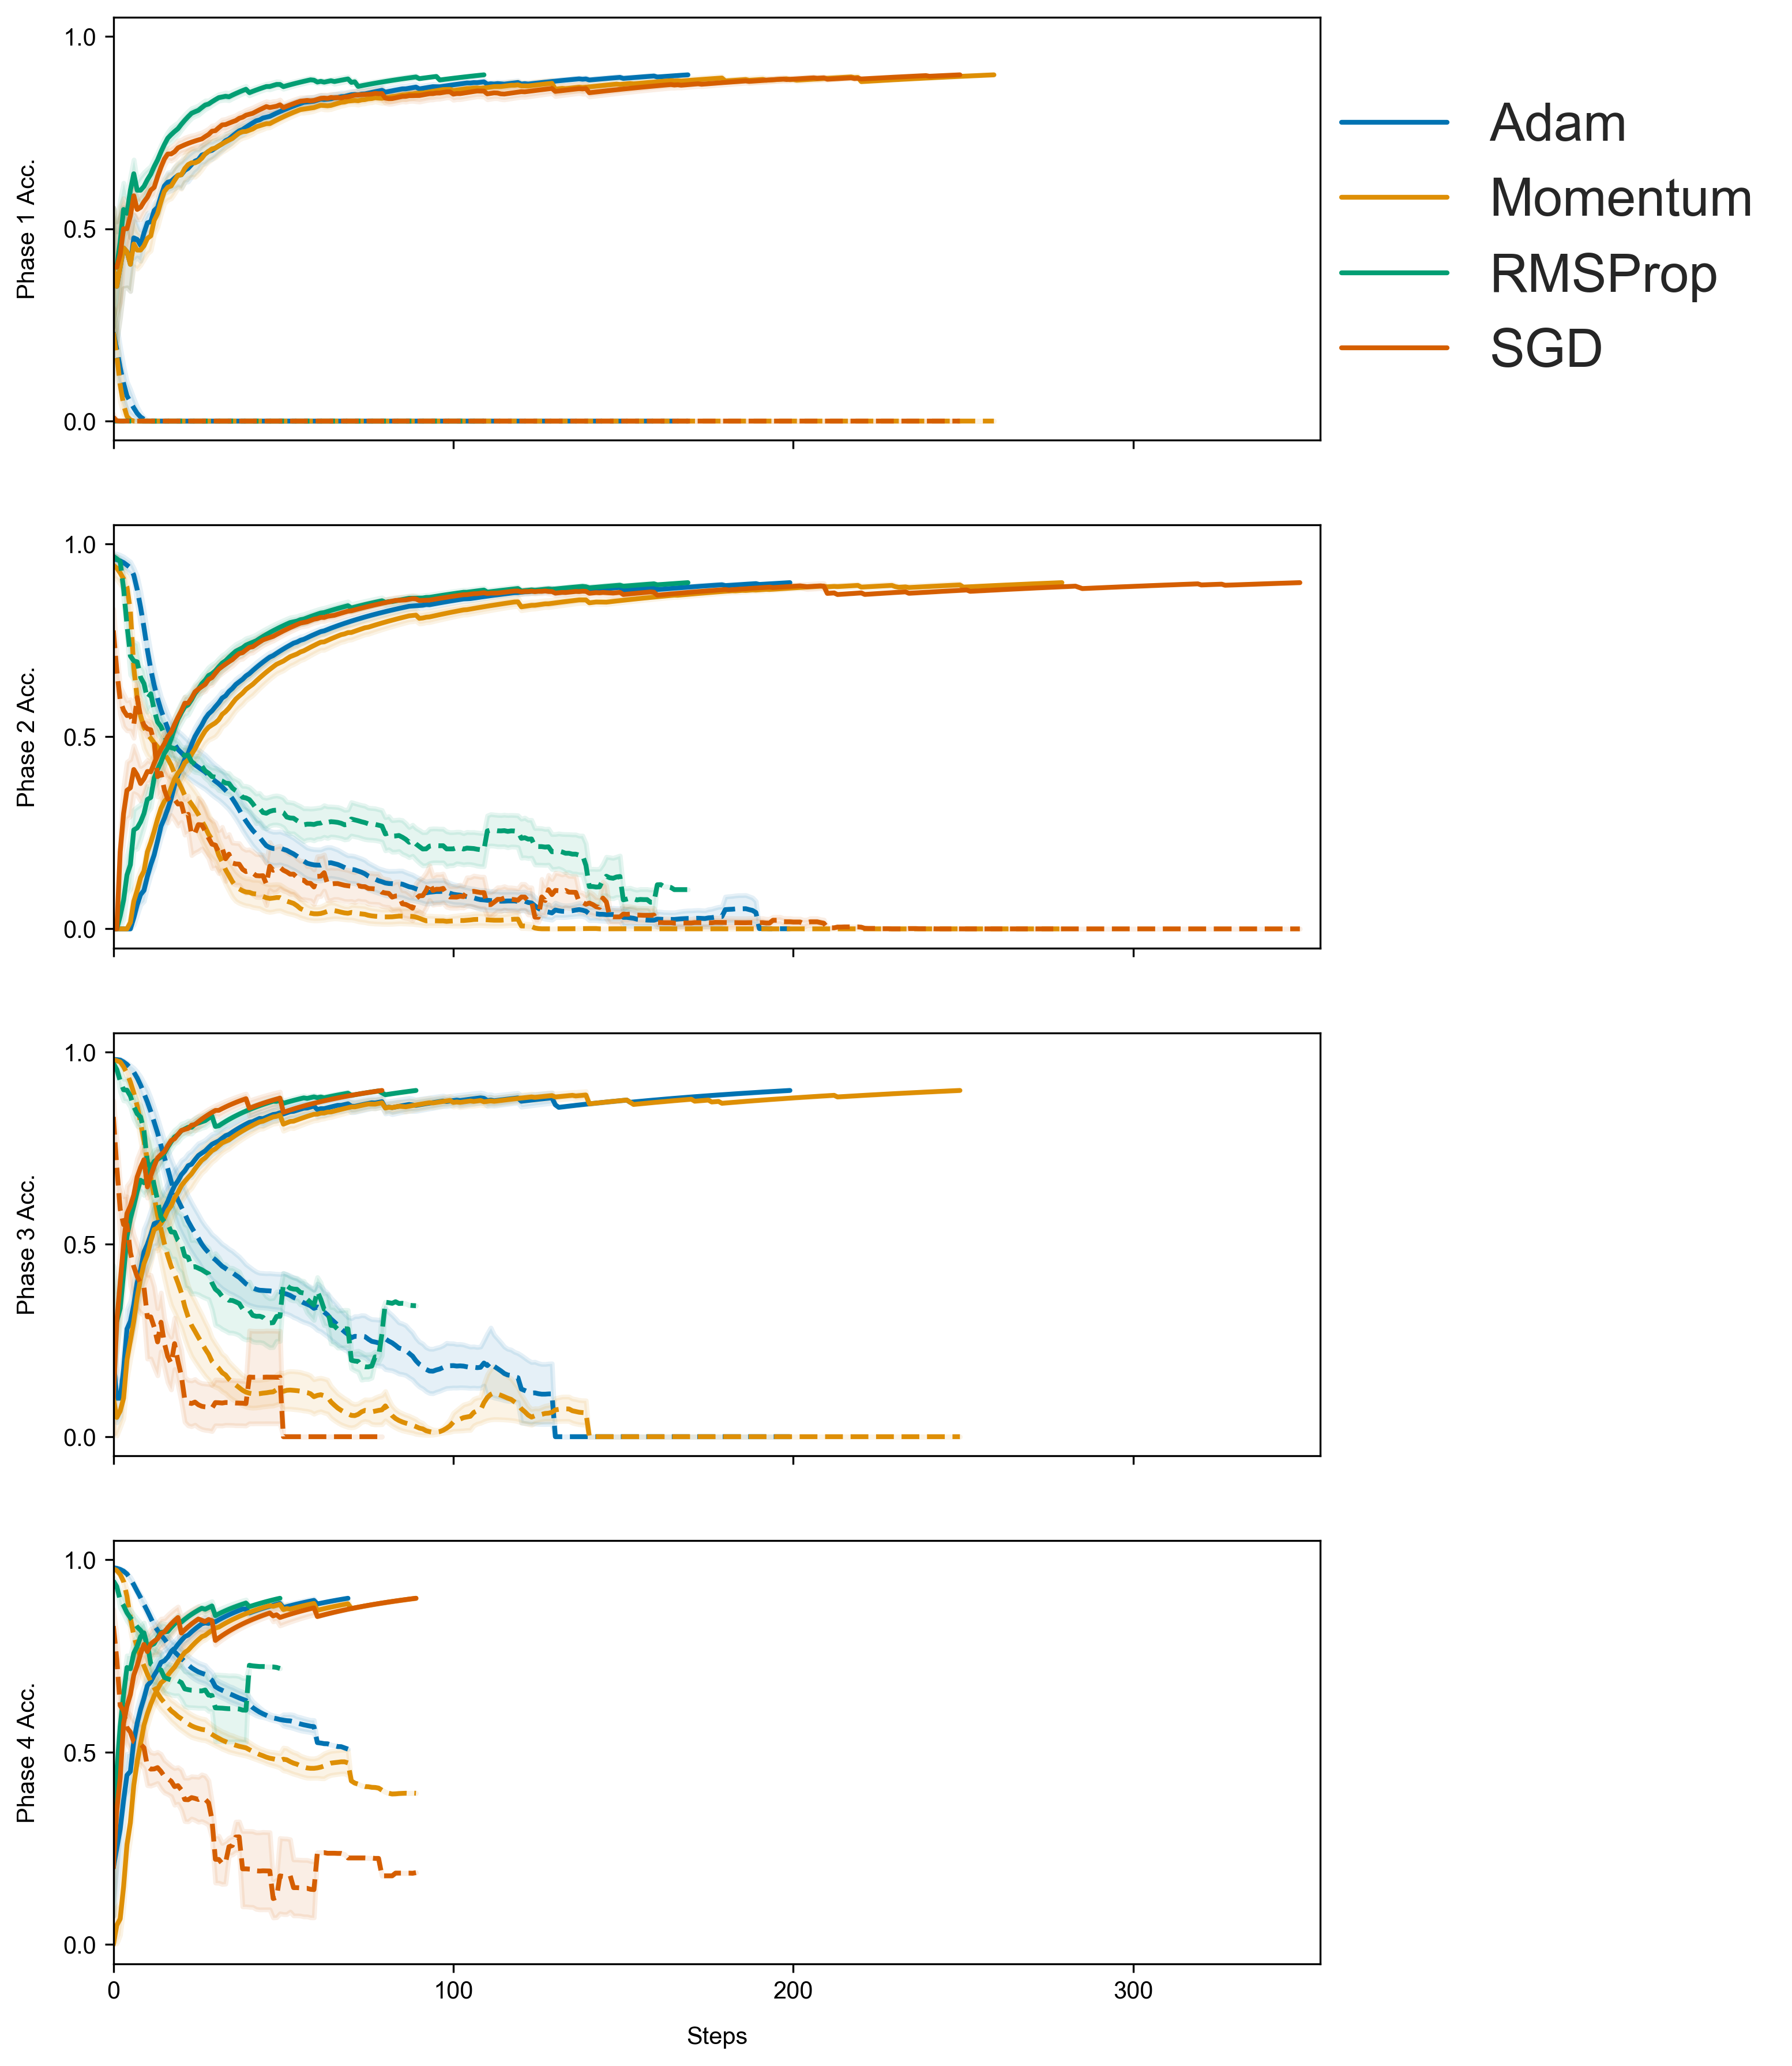

In [6]:
threshold = 1
fig, axarr = plt.subplots(4, 1, figsize=(9, 6), dpi=300, sharex=True)
sns.set_style('ticks')
sns.set_context('poster')
colors = sns.color_palette('colorblind', len(data.keys()))
for j in range(len(axarr)):
    ax = axarr[j]
    for i, (k, v) in enumerate(sorted(data.items(), key=lambda x: x[0])):
        y = v['d{}_avg'.format((j + 1) % 2 + 1)][j][v['count'][j] >= threshold]
        yerr = v['d{}_sem'.format((j + 1) % 2 + 1)][j][v['count'][j] >= threshold]
        x = np.arange(len(y))
        ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        ax.plot(x, y, color=colors[i], linestyle='--', linewidth=2)
        y = v['online_avg'][j][v['count'][j] >= threshold]
        yerr = v['online_sem'][j][v['count'][j] >= threshold]
        x = np.arange(len(y))
        ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        ax.plot(x, y, label=optimizer_nice_names[k], color=colors[i], linestyle='-', linewidth=2)
        ax.set_ylim(-0.05, 1.05)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_xlim((0, 355))
    ax.set_ylabel('Phase {} Acc.'.format(j + 1), labelpad=10)
ax.set_xlabel('Steps', labelpad=10)
plt.legend(frameon=False, loc=(1, 3.7))
plt.subplots_adjust(top=2)

In [ ]:
threshold = 1
fig, ax = plt.subplots(1, 1, figsize=(9, 3), dpi=300)
sns.set_style('ticks')
sns.set_context('poster')
colors = sns.color_palette('colorblind', len(data.keys()))
for i, (k, v) in enumerate(sorted(data.items(), key=lambda x: x[0])):
    j = 1
    y = v['d1_avg'][j][v['count'][j] >= threshold]
    yerr = v['d1_sem'][j][v['count'][j] >= threshold]
    x = np.arange(len(y))
    ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
    ax.plot(x, y, color=colors[i], linestyle='--', linewidth=2)
    y = v['online_avg'][j][v['count'][j] >= threshold]
    yerr = v['online_sem'][j][v['count'][j] >= threshold]
    x = np.arange(len(y))
    ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
    ax.plot(x, y, label=optimizer_nice_names[k], color=colors[i], linestyle='-', linewidth=2)
    x = np.array(sorted(v['phase_lengths'][j])[:-1])
    y = np.zeros(x.shape)
    for a, b in enumerate(x):
        y[a] = v['online_avg'][j][v['count'][j] >= threshold][b]
    ax.plot(x, y, linewidth=0, marker='x', markersize=10, color=colors[i])
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xlim((0, 355))
ax.set_xlabel('Steps', labelpad=10)
ax.set_ylabel('Accuracy', labelpad=10)
ax.set_title('Phase 2', pad=10)
plt.legend(frameon=False, loc=(1, 0.1))
fig.savefig('phase_2_comparison.png', bbox_inches='tight')

In [ ]:
third_phase_lengths = {optimizer: list() for optimizer in only_best['optimizer'].unique()}
for _, row in only_best.iterrows():
    third_phase_lengths[row['optimizer']].append(row['phase_length'][2])
print('|-----------|------------------|')
print('| Optimizer | Steps in Phase 3 |')
print('|-----------|------------------|')
for optimizer in sorted(list(third_phase_lengths.keys())):
    print('| {0:>9} | {1:>6.2f}±{2:<5.2f}     |'.format(
        optimizer,
        np.mean(third_phase_lengths[optimizer]),
        np.std(third_phase_lengths[optimizer]) / np.sqrt(len(third_phase_lengths[optimizer]))))
print('|-----------|------------------|')

In [ ]:
sns.set_context('poster')
boxplot_data = {'optimizer': [], 'third_phase_lengths': []}
for optimizer in sorted(list(third_phase_lengths.keys())):
    for phase_length in third_phase_lengths[optimizer]:
        boxplot_data['optimizer'].append(optimizer_nice_names[optimizer])
        boxplot_data['third_phase_lengths'].append(phase_length)
fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=150)
ax.set_ylim(0, 275)
ax.set_ylabel('Steps in Phase 3', labelpad=10)
sns.boxplot(x=boxplot_data['optimizer'], y=boxplot_data['third_phase_lengths'], ax=ax)
sns.despine(offset=10, trim=True)
fig.savefig('phase_3_steps.png', bbox_inches='tight')

In [ ]:
sns.set_context('poster')
boxplot_data = {'optimizer': [], 'third_phase_lengths': []}
for optimizer in sorted(list(third_phase_lengths.keys())):
    for phase_length in third_phase_lengths[optimizer]:
        boxplot_data['optimizer'].append(optimizer_nice_names[optimizer])
        boxplot_data['third_phase_lengths'].append(phase_length)
fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=150)
ax.set_ylabel('Steps in Phase 3', labelpad=10)
ax.set_ylim(0, 275)
sns.violinplot(x=boxplot_data['optimizer'], y=boxplot_data['third_phase_lengths'], cut=0, ax=ax)
sns.despine(offset=10, trim=True)

In [ ]:
plt.close()
phase_lengths = {optimizer: [list() for _ in max_phase_lengths] for optimizer in only_best['optimizer'].unique()}
for _, row in only_best.iterrows():
    optimizer = row['optimizer']
    for i, phase_length in enumerate(row['phase_length']):
        phase_lengths[optimizer][i].append(phase_length)
sns.set_style('ticks')
sns.set_context('poster')
colors = sns.color_palette('colorblind', len(phase_lengths.keys()))
fig, axmat = plt.subplots(len(phase_lengths.keys()),
                          len(max_phase_lengths),
                          figsize=(5 * len(max_phase_lengths), 5 * len(phase_lengths.keys())),
                          sharex=True,
                          sharey=True)
for j, optimizer in enumerate(sorted(list(phase_lengths.keys()))):
    for i in range(len(max_phase_lengths)):
        axmat[i, j].set_xlim(0, max(max_phase_lengths) + 1)
        axmat[i, j].set_ylim(0, 5.1)
        axmat[i, j].hist(phase_lengths[optimizer][i], bins=range(0, max(max_phase_lengths), 10), color=colors[j])
        if i == 0:
            axmat[i, j].set_title(optimizer_nice_names[optimizer], pad=10)
        if i == len(phase_lengths.keys()) - 1:
            axmat[i, j].set_xlabel('Phase Length', labelpad=17)
            axmat[i, j].set_xticks([0, 100, 200, 300])
        if j == 0:
            axmat[i, j].set_ylabel('Phase {}'.format(i + 1), labelpad=12)
            axmat[i, j].set_yticks([0, 1, 2, 3, 4, 5])
plt.tight_layout()

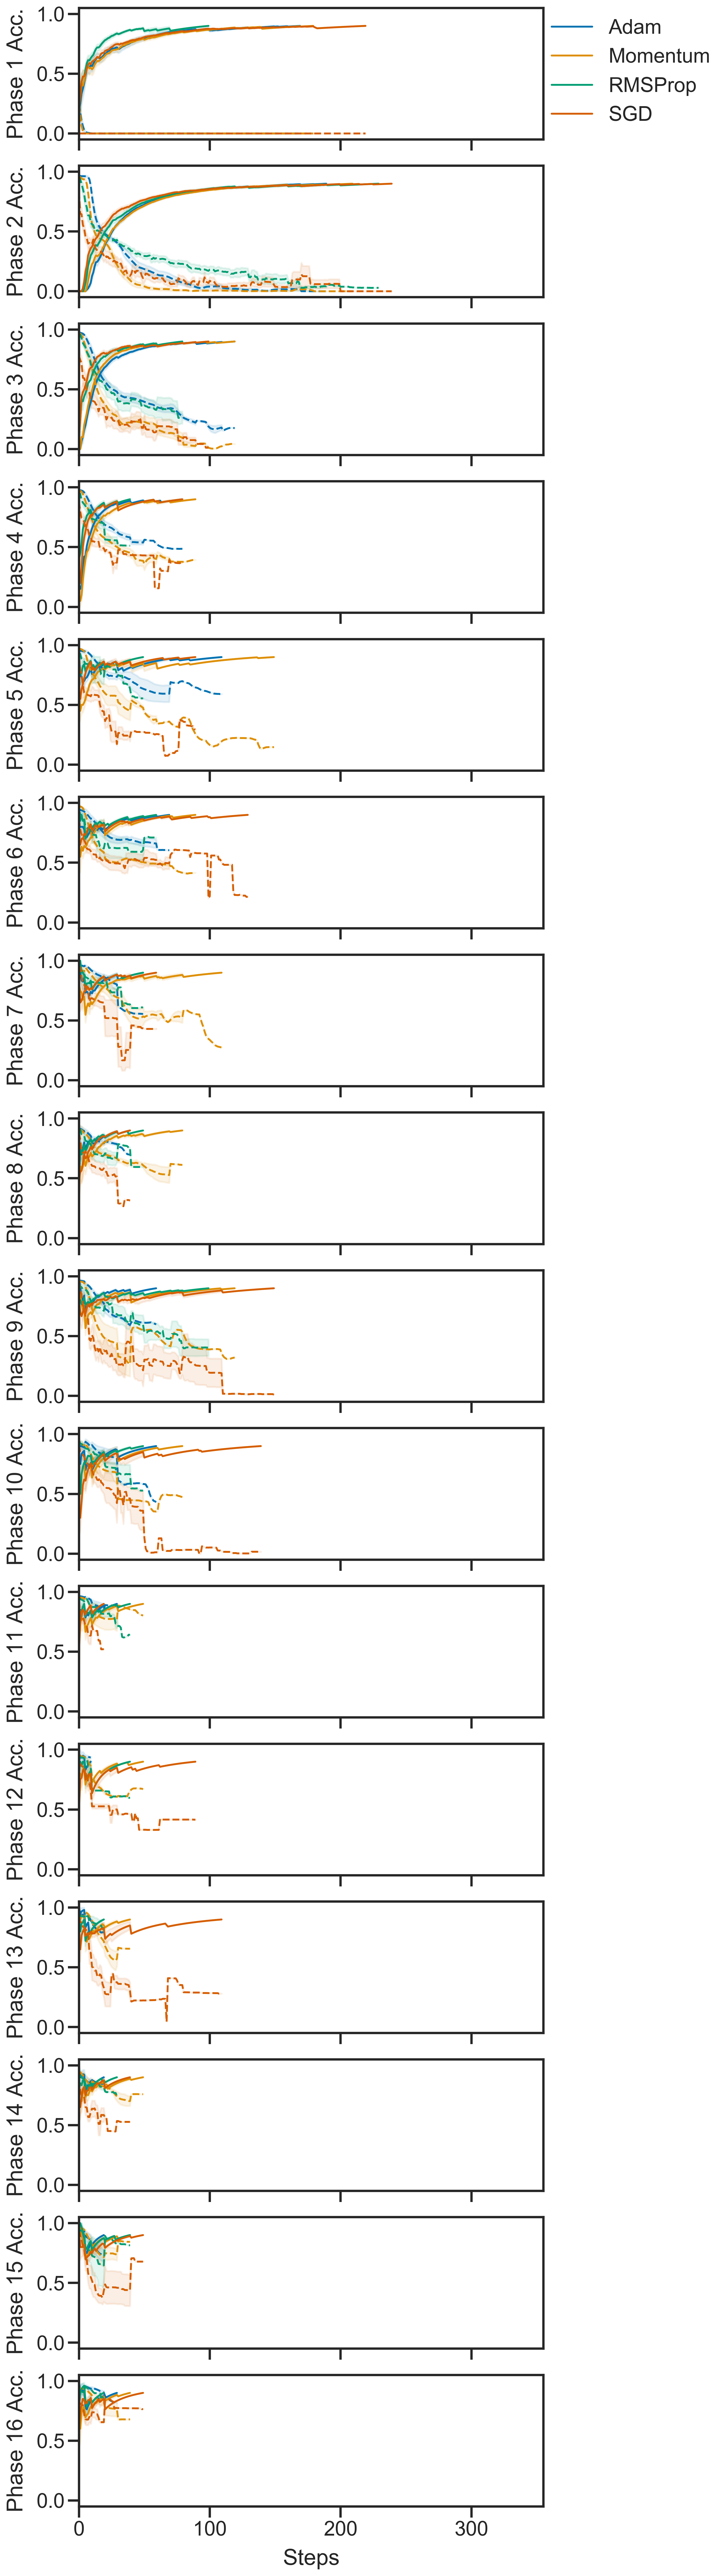

In [13]:
threshold = 1
fig, axarr = plt.subplots(16, 1, figsize=(9, 20), dpi=300, sharex=True)
sns.set_style('ticks')
sns.set_context('poster')
colors = sns.color_palette('colorblind', len(data.keys()))
for j in range(len(axarr)):
    ax = axarr[j]
    for i, (k, v) in enumerate(sorted(data.items(), key=lambda x: x[0])):
        y = v['d{}_avg'.format((j + 1) % 2 + 1)][j][v['count'][j] >= threshold]
        yerr = v['d{}_sem'.format((j + 1) % 2 + 1)][j][v['count'][j] >= threshold]
        x = np.arange(len(y))
        ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        ax.plot(x, y, color=colors[i], linestyle='--', linewidth=2)
        y = v['online_avg'][j][v['count'][j] >= threshold]
        yerr = v['online_sem'][j][v['count'][j] >= threshold]
        x = np.arange(len(y))
        ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        ax.plot(x, y, label=optimizer_nice_names[k], color=colors[i], linestyle='-', linewidth=2)
        ax.set_ylim(-0.05, 1.05)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_xlim((0, 355))
    ax.set_ylabel('Phase {} Acc.'.format(j + 1), labelpad=10)
ax.set_xlabel('Steps', labelpad=10)
plt.legend(frameon=False, loc=(1, 18.05))
plt.subplots_adjust(top=2)
plt.savefig('sixteen_phases.png', bbox_inches='tight')

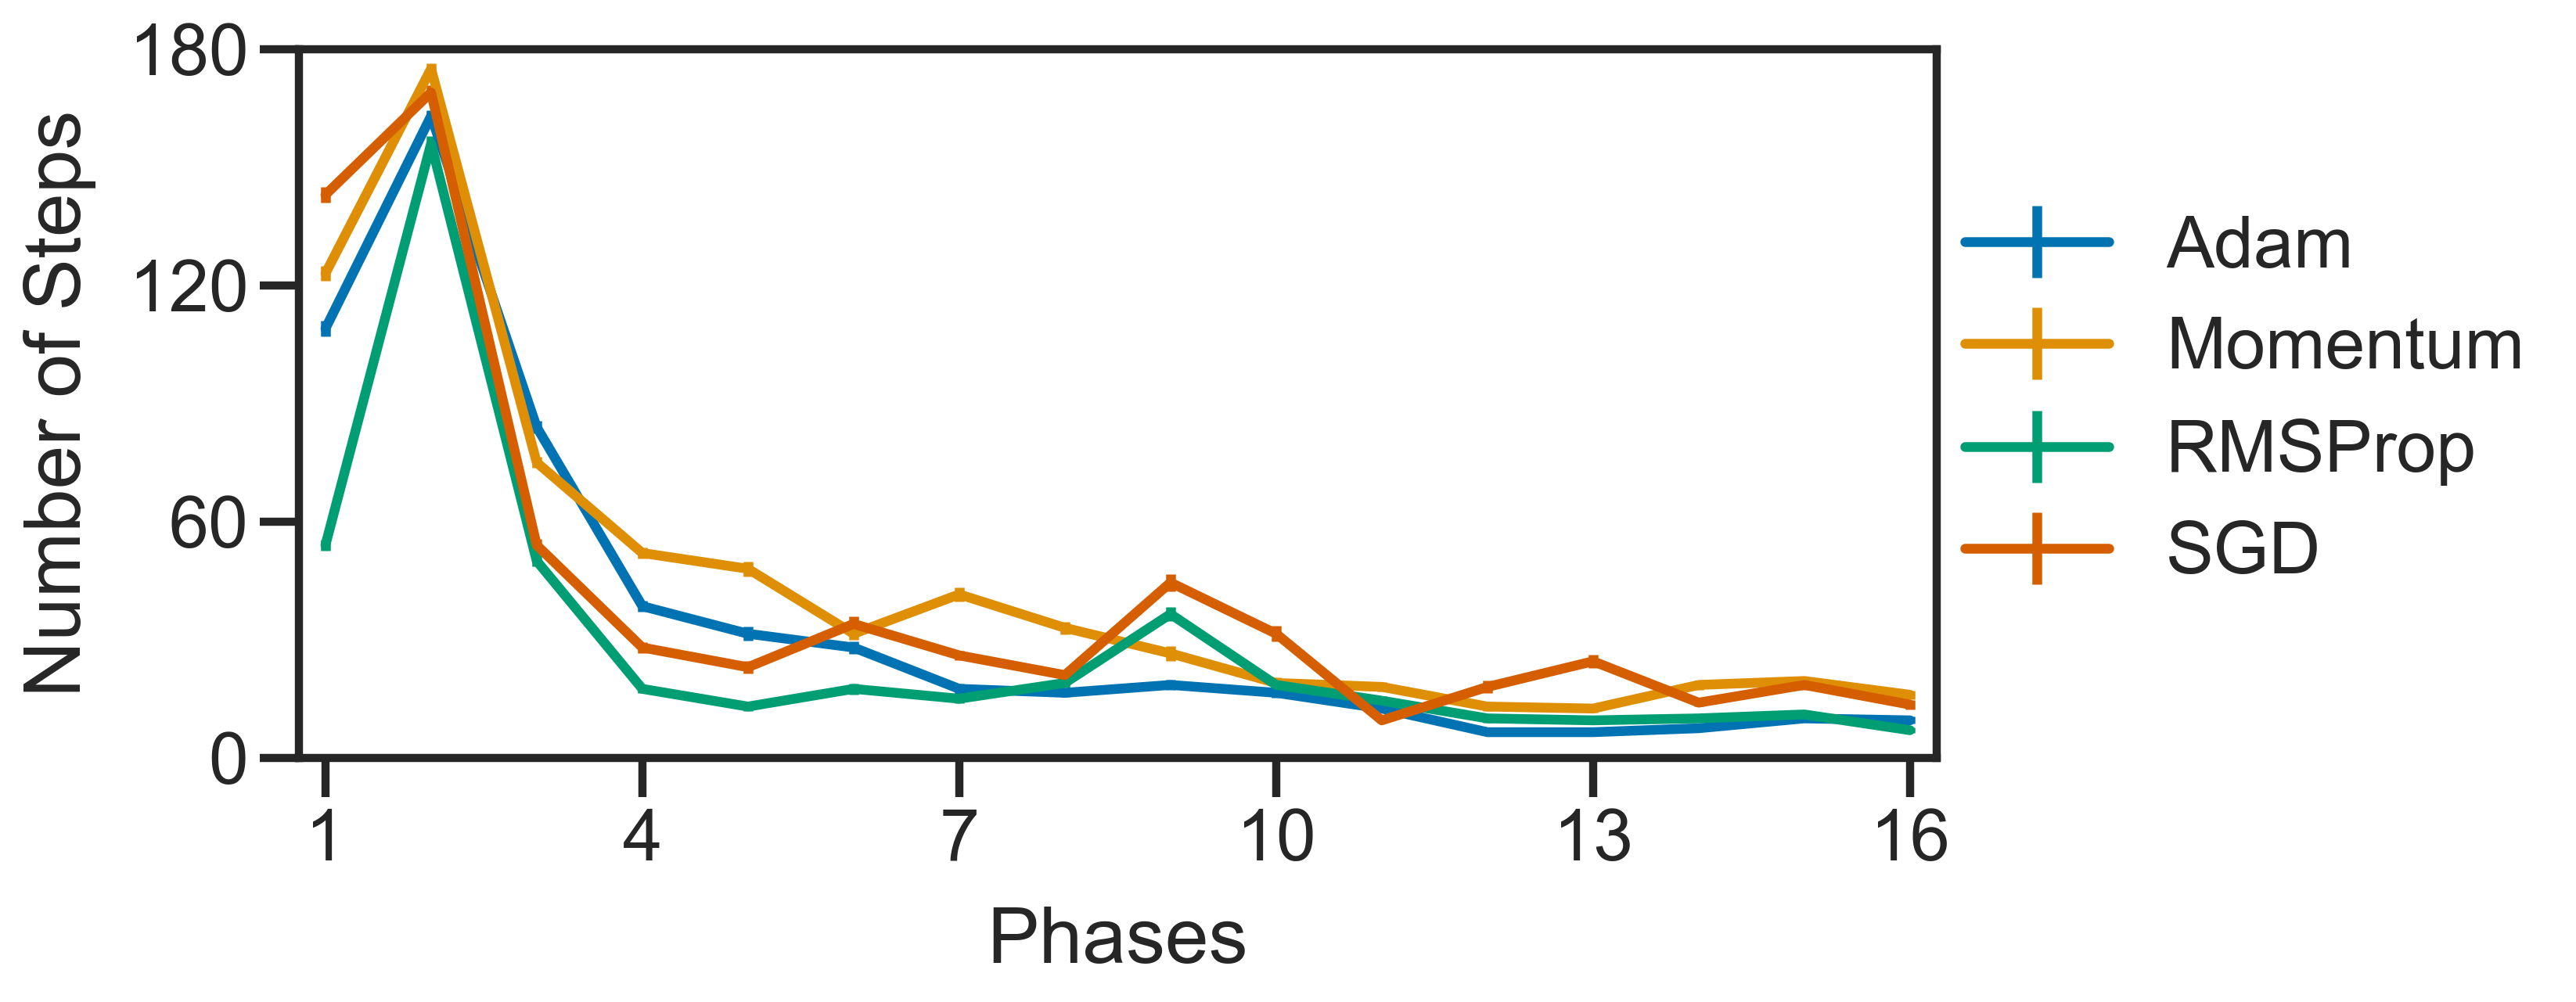

In [14]:
threshold = 1
num_phases = 16
fig, ax = plt.subplots(1, 1, figsize=(9, 4), dpi=300, sharex=True)
sns.set_style('ticks')
sns.set_context('poster')
colors = sns.color_palette('colorblind', len(data.keys()))
for i, (k, v) in enumerate(sorted(data.items(), key=lambda x: x[0])):
    y = np.zeros(num_phases)
    yerr = np.copy(y)
    for j in range(num_phases):
        y[j] = np.mean(v['phase_lengths'][j])
        yerr[j] = np.sqrt(np.std(v['phase_lengths'][j]) / len(v['phase_lengths'][j]))
    ax.errorbar(range(1, num_phases + 1), y, yerr=yerr, label=optimizer_nice_names[k], color=colors[i])
ax.set_ylim(0, 180)
ax.set_yticks([0, 60, 120, 180])
ax.set_xticks([1, 4, 7, 10, 13, 16])
ax.set_xlim((1 - 0.25, num_phases + 0.25))
ax.set_ylabel('Number of Steps'.format(j + 1), labelpad=10)
ax.set_xlabel('Phases', labelpad=10)
plt.legend(frameon=False, loc=(1, 0.2))
plt.savefig('phase_lengths.png', bbox_inches='tight')